In [1]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from env import PredatorPreyTask
from utils import plot_episode

C:\Users\Romain Zimmer\Anaconda3\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


In [2]:
class CommNetPP:
    
    def __init__(self, sess, N, grid_size, embedding_size = 50, lr = 1e-3, alpha = 0.03, rnn_controler = False):
        
        self.N = N
        self.embedding_size = embedding_size
        self.n_actions = 6 # Stay, North, South, East, West, Communicate
        self.grid_size = grid_size
        self.rnn_controler = rnn_controler
        
        if rnn_controler:
            self.build_rnn_controler()
        else:
            self.build_controler()
        
        
        self.alpha = alpha
        self.build_reinforce()
        with tf.variable_scope('Reinforce_optimizer'):
            self.train_op =  tf.train.RMSPropOptimizer(lr).minimize(self.reinforce_loss)
            
        
        self.sess = sess
        self.sess.run(tf.global_variables_initializer())
        
    def encode(self, inputs):
        
        agent_positions = inputs[0]
        prey_positions = inputs[1]
        
        with tf.variable_scope('Encoder'):
        
            self.agent_position_embedding = tf.get_variable("agent_position_embedding",
                                             [self.grid_size**2 + 1, self.embedding_size]) # 0 not used
            
            self.embedded_agent_position = tf.nn.embedding_lookup(self.agent_position_embedding, agent_positions)
            
            
            
            
            self.prey_position_embedding = tf.get_variable("prey_position_embedding",
                                             [self.grid_size**2 + 1, self.embedding_size]) # 0 --> cannot see the prey
            
            self.embedded_prey_position = tf.nn.embedding_lookup(self.prey_position_embedding, prey_positions)
        
        
        h0 = tf.concat([self.embedded_agent_position, self.embedded_prey_position], axis = 2)
        h0_seq = tf.unstack(h0, axis = 1)
        
        return h0_seq
    
    def build_f(self, name, h, c, h0 = None):
        
        with tf.variable_scope(name, reuse = tf.AUTO_REUSE):
            
            if h0 is not None and c is not None:
            
                b1 = tf.get_variable('b1', shape = (1, 2 * self.embedding_size))
                W1 = tf.get_variable('W1', shape = (3 * 2 * self.embedding_size,
                                                  2 * self.embedding_size))
                
                W2 = tf.get_variable('W2', shape = (2 * self.embedding_size,
                                                  2 * self.embedding_size))
                
                concat = tf.concat([h, c, h0], axis = 1)
            
            elif h0 is not None and c is None:
                b1 = tf.get_variable('b1', shape = (1, 2* self.embedding_size))
                
                W1 = tf.get_variable('W1', shape = (2 * 2 * self.embedding_size,
                                                  2 * self.embedding_size))
                
                W2 = tf.get_variable('W2', shape = (2 * self.embedding_size,
                                                  2 * self.embedding_size))
                
                concat = tf.concat([h, h0], axis = 1)
                
            elif c is not None and h0 is None:
                
                b1 = tf.get_variable('b1', shape = (1, 2 * self.embedding_size))
                
                W1 = tf.get_variable('W1', shape = (2 * 2 *self.embedding_size,
                                                  2 * self.embedding_size))
                
                W2 = tf.get_variable('W2', shape = (2 * self.embedding_size,
                                                  2 * self.embedding_size))
                
                concat = tf.concat([h, c], axis = 1)
                
            else:
                
                b1 = tf.get_variable('b1', shape = (1, 2 *self.embedding_size))
                
                W1 = tf.get_variable('W1', shape = (2 * self.embedding_size,
                                                  2 * self.embedding_size))
                
                W2 = tf.get_variable('W2', shape = (2 * self.embedding_size,
                                                  2 * self.embedding_size))
                
                concat = h
                
                
            b2 = tf.get_variable('b2', shape = (1, 2 * self.embedding_size))
            
            dense1 =tf.nn.relu(tf.einsum("ij,jk->ik", concat, W1) + b1)
            dense2 = tf.nn.relu(tf.einsum("ij,jk->ik", dense1, W2) + b2)
            
            return dense2
        
    def decode_movement(self, h):
        
        with tf.variable_scope('Decoder_movement', reuse = tf.AUTO_REUSE):
            
            W = tf.get_variable('W', shape = (2 * self.embedding_size,
                                                  self.n_actions - 1))
            
            b = tf.get_variable('b', shape = (1, self.n_actions - 1))
            
            policy_logit = tf.einsum("ij,jk->ik", h, W) + b
        
            return policy_logit
        
    def decode_communication(self, h):
        
        with tf.variable_scope('Decoder_communication', reuse = tf.AUTO_REUSE):
            
            W = tf.get_variable('W', shape = (2 * self.embedding_size,
                                                  2))
            
            b = tf.get_variable('b', shape = (1, 2))
            
            policy_logit = tf.einsum("ij,jk->ik", h, W) + b
        
            return policy_logit
        
    def communicate(self, h_seq):
        
        return tf.add_n(h_seq) / tf.maximum(1. ,(tf.reduce_sum(self.communication_mask, axis = 1, keepdims = True) - 1))
    
    def sample_actions(self, log_proba):
        
        action = tf.multinomial(log_proba, num_samples = 1)
        
        return action
    
        
    def build_controler(self):
        
        self.inputs = tf.placeholder(tf.int32, shape = (None, 2, self.N))
        self.communication_mask = tf.placeholder(tf.float32, shape = (None, self.N))
        unstacked_communication_mask = [tf.reshape(m, [-1,1]) for m in tf.unstack(self.communication_mask, axis = 1)]
        
        h0_seq = self.encode(tf.unstack(self.inputs, axis = 1))
        
        c0_seq = [self.communicate([h0_seq[j] * unstacked_communication_mask[j]  for j in range(self.N) if j != i]) for i in range(self.N)]
        
        h1_seq = [self.build_f("Comm_step_1", h0_seq[j], c0_seq[j], None) for j in range(self.N)]
        c1_seq = [self.communicate([h1_seq[j] * unstacked_communication_mask[j] for j in range(self.N) if j != i]) for i in range(self.N)]
        
        self.h2_seq = [self.build_f("Comm_step_2", h1_seq[j], c1_seq[j], h0_seq[j]) for j in range(self.N)]
        
        self.layers = {'h0_seq': h0_seq, 'c0_seq': c0_seq, 'h1_seq': h1_seq, 'c1_seq':c1_seq, 'h2_seq': self.h2_seq}
        
        
        self.movement_policy_logit_seq = [self.decode_movement(h2) for h2 in self.h2_seq]
        self.communication_policy_logit_seq = [self.decode_communication(h2) for h2 in self.h2_seq]
        
        self.movement_log_proba_seq = [tf.nn.log_softmax(policy_logit, axis = 1) for policy_logit in self.movement_policy_logit_seq]
        self.communication_log_proba_seq = [tf.nn.log_softmax(policy_logit, axis = 1) for policy_logit in self.communication_policy_logit_seq]
        
        self.movement_action_seq = [self.sample_actions(log_proba) for log_proba in self.movement_log_proba_seq]
        self.communication_action_seq = [self.sample_actions(log_proba) for log_proba in self.communication_log_proba_seq]
        
    def build_rnn(self, name, h, c, cell_state):
        
        with tf.variable_scope(name, reuse = tf.AUTO_REUSE):
            
            rnn_cell = tf.nn.rnn_cell.GRUCell(2 * self.embedding_size)
            
            #add sequence lenght dimension: [batch_size, embedding_dimension] --> [batch_size, 1, embedding_dimension]
            concat = tf.expand_dims(tf.concat([h, c], axis = 1), 1)
            
            output, last_states = tf.nn.dynamic_rnn(inputs = concat, cell = rnn_cell, initial_state = cell_state)
            
            #removing sequence lenght dimension: [batch_size, 1, embedding_dimension] --> [batch_size, embedding_dimension]  
            output = tf.squeeze(output, axis = 1)
            return output, last_states
    
    def build_rnn_controler(self):
        
        self.inputs = tf.placeholder(tf.int32, shape = (None, 2, self.N))
        self.communication_mask = tf.placeholder(tf.float32, shape = (None, self.N))
        unstacked_communication_mask = [tf.reshape(m, [-1,1]) for m in tf.unstack(self.communication_mask, axis = 1)]
        
        self.cell_state = tf.placeholder(tf.float32, shape = (None, 2 * self.embedding_size, self.N))
        unstacked_cell_state = tf.unstack(self.cell_state, axis = 2)
        
        
        h0_seq = self.encode(tf.unstack(self.inputs, axis = 1))
        
        c_seq = [self.communicate([h0_seq[j] * unstacked_communication_mask[j]  for j in range(self.N) if j != i]) for i in range(self.N)]
        
        rnn_modules = [self.build_rnn("Comm_step_rnn", h0_seq[j], c_seq[j], unstacked_cell_state[j]) for j in range(self.N)]
        
        self.h_seq = [x[0] for x in rnn_modules]
        
        self.layers = {'h0_seq': h0_seq, 'c_seq': c_seq, 'h_seq': self.h_seq}
        
        self.new_cell_state_seq = tf.stack([x[1] for x in rnn_modules], axis = 2)
        
        self.movement_policy_logit_seq = [self.decode_movement(h) for h in self.h_seq]
        self.communication_policy_logit_seq = [self.decode_communication(h) for h in self.h_seq]
        
        self.movement_log_proba_seq = [tf.nn.log_softmax(policy_logit, axis = 1) for policy_logit in self.movement_policy_logit_seq]
        self.communication_log_proba_seq = [tf.nn.log_softmax(policy_logit, axis = 1) for policy_logit in self.communication_policy_logit_seq]
        
        self.movement_action_seq = [self.sample_actions(log_proba) for log_proba in self.movement_log_proba_seq]
        self.communication_action_seq = [self.sample_actions(log_proba) for log_proba in self.communication_log_proba_seq]
            
    def build_baseline(self, h):
        
        with tf.variable_scope('Baseline', reuse = tf.AUTO_REUSE):
            
            W = tf.get_variable('W', shape = (2 * self.embedding_size,
                                                  1))
            
            b = tf.get_variable('b', shape = (1,))
            
            
            baseline = tf.einsum("ij,jk->ik", h, W) + b
            
            return baseline
            

    def build_reinforce(self):
        
        if self.rnn_controler:
            self.baselines = tf.concat([self.build_baseline(h) for h in self.h_seq], axis = 1)
        else:
            self.baselines = tf.concat([self.build_baseline(h2) for h2 in self.h2_seq], axis = 1)
                    
        self.reward_values = tf.placeholder(tf.float32, shape = (None, self.N))
        self.reward_values_cumsum = tf.cumsum(self.reward_values, axis = 0, reverse = True)
        
        self.baseline_values =  tf.placeholder(tf.float32, shape = (None, self.N))
               
        
        self.movement_action_taken = tf.placeholder(tf.int32, shape = (None, self.N))
        unstacked_movement_action_taken = tf.unstack(self.movement_action_taken, axis = 1)
        
        self.movement_neg_log_p = tf.transpose(tf.concat([[tf.nn.sparse_softmax_cross_entropy_with_logits(labels=unstacked_movement_action_taken[j],
                                                    logits=self.movement_policy_logit_seq[j])] for j in range(self.N)], axis = 0))
        
        
        self.communication_action_taken = tf.placeholder(tf.int32, shape = (None, self.N))
        unstacked_communication_action_taken = tf.unstack(self.communication_action_taken, axis = 1)
        
        self.communication_neg_log_p = tf.transpose(tf.concat([[tf.nn.sparse_softmax_cross_entropy_with_logits(labels=unstacked_communication_action_taken[j],
                                                    logits=self.communication_policy_logit_seq[j])] for j in range(self.N)], axis = 0))
        
        self.neg_log_p = self.movement_neg_log_p + self.communication_neg_log_p
        #surrogate loss (- dtheta)
        
        self.reinforce_loss = tf.reduce_sum(tf.multiply(self.neg_log_p, self.reward_values_cumsum - self.baseline_values))
        self.reinforce_loss += self.alpha * tf.reduce_sum(tf.square(self.reward_values_cumsum - self.baselines))
        self.reinforce_loss /= self.N
        
    def take_action(self, state, communication_mask, cell_state):
        
        
        if cell_state is None:
            movement_action_seq, communication_action_seq, baselines= self.sess.run([self.movement_action_seq, 
                                                                                 self.communication_action_seq, self.baselines], 
                                                                                {self.inputs: [state],
                                                                                self.communication_mask: [communication_mask]})
            return [a[0,0] for a in movement_action_seq], [a[0,0] for a in communication_action_seq],  baselines
            
            
        else:
            movement_action_seq, communication_action_seq, baselines, new_state_cell_seq= self.sess.run([self.movement_action_seq, 
                                                                                     self.communication_action_seq,
                                                                                     self.baselines,
                                                                                     self.new_cell_state_seq], 
                                                                                {self.inputs: [state],
                                                                                self.communication_mask: [communication_mask],
                                                                                self.cell_state: [cell_state]})
            return np.squeeze(movement_action_seq, axis = (1,2)), np.squeeze(communication_action_seq, axis = (1,2)),  baselines, np.squeeze(new_state_cell_seq, axis = (0,))
    
    def reinforce_train(self, env, n_episodes, T):
        
        
        history = {'reward' : [],  'loss': [], 'terminal_state': []}
        
        for _ in tqdm_notebook(range(n_episodes), "REINFORCE"):
            
            
            rollout = policy_rollout(T, env, self)
            
            episode_len = rollout['reward_seq'].shape[0]
            
            history['reward'].append(np.sum(np.mean(rollout['reward_seq'], axis = 1)))
            history['terminal_state'].append(rollout['terminal_state'])
                
            feed_dict = {}
            feed_dict[self.inputs] = rollout['state_seq']
            if self.rnn_controler:
                feed_dict[self.cell_state] = rollout['cell_state_seq'][:-1]
            feed_dict[self.communication_mask] = rollout['communication_action_seq'][:-1]
            feed_dict[self.reward_values] = rollout['reward_seq']
            feed_dict[self.baseline_values] = rollout['baseline_seq']
            feed_dict[self.movement_action_taken] = rollout['movement_action_seq']
            feed_dict[self.communication_action_taken] = rollout['communication_action_seq'][1:]
            
            _, loss = self.sess.run([self.train_op, self.reinforce_loss], feed_dict = feed_dict)
            
            history['loss'].append(loss)
            
        return history
            
            
            
            
            
            
            
        

In [3]:
# episode generation for reinforcement learning
def policy_rollout(T, env, agent):
    
    state_seq = []
    movement_action_seq = []
    communication_action_seq = [np.zeros(agent.N)]
    if agent.rnn_controler:
        cell_state_seq = [np.zeros((2 * agent.embedding_size, agent.N))]
    reward_seq = []
    baseline_seq = []
    
    
    state, terminal_state = env.reset()
    while terminal_state:
        state, terminal_state = env.reset()
    
    t = 0
    
    while not terminal_state and t < T:
        t +=1
        
        state_seq.append(state)
        if agent.rnn_controler:
            movement_action, communication_action, baseline, new_cell_state = agent.take_action(state, communication_action_seq[-1], cell_state_seq[-1])
            cell_state_seq.append(new_cell_state)
        else:
            movement_action, communication_action, baseline = agent.take_action(state, communication_action_seq[-1], None)
            
        
        state, reward, terminal_state = env.step(movement_action, communication_action)
        
        movement_action_seq.append(movement_action)
        communication_action_seq.append(communication_action)
        reward_seq.append(reward)
        baseline_seq.append(baseline)
    
    rollout = dict()
    rollout['state_seq'] = np.array(state_seq)
    rollout['movement_action_seq'] = np.array(movement_action_seq)
    rollout['communication_action_seq'] = np.array(communication_action_seq)
    rollout['reward_seq'] = np.array(reward_seq)
    rollout['baseline_seq'] = np.squeeze(np.array(baseline_seq), axis = (1,))
    rollout['terminal_state'] = terminal_state
    if agent.rnn_controler:
        rollout['cell_state_seq'] = cell_state_seq
        
    return rollout

In [9]:
N = 4
grid_size = 5
T = 100
n_episodes = 1

HBox(children=(IntProgress(value=0, description='REINFORCE', max=1, style=ProgressStyle(description_width='initial')), HTML(value='')))


avg reward


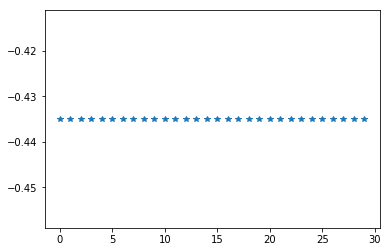

reward


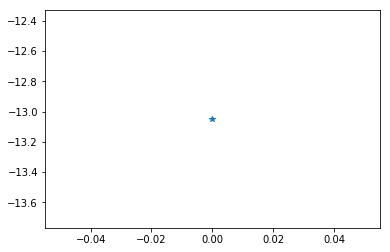

avg terminal_state


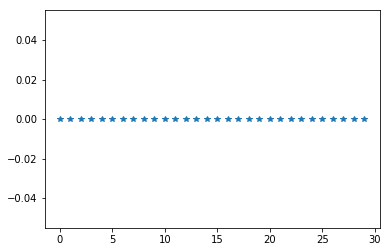

terminal_state


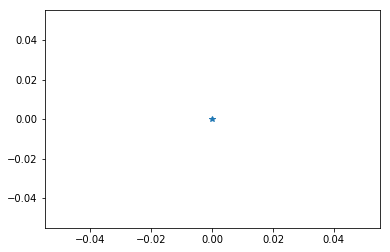

loss


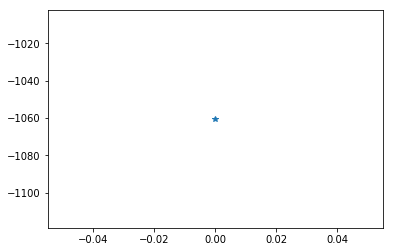

New policy rollout ? (y/n)y

Catched: True


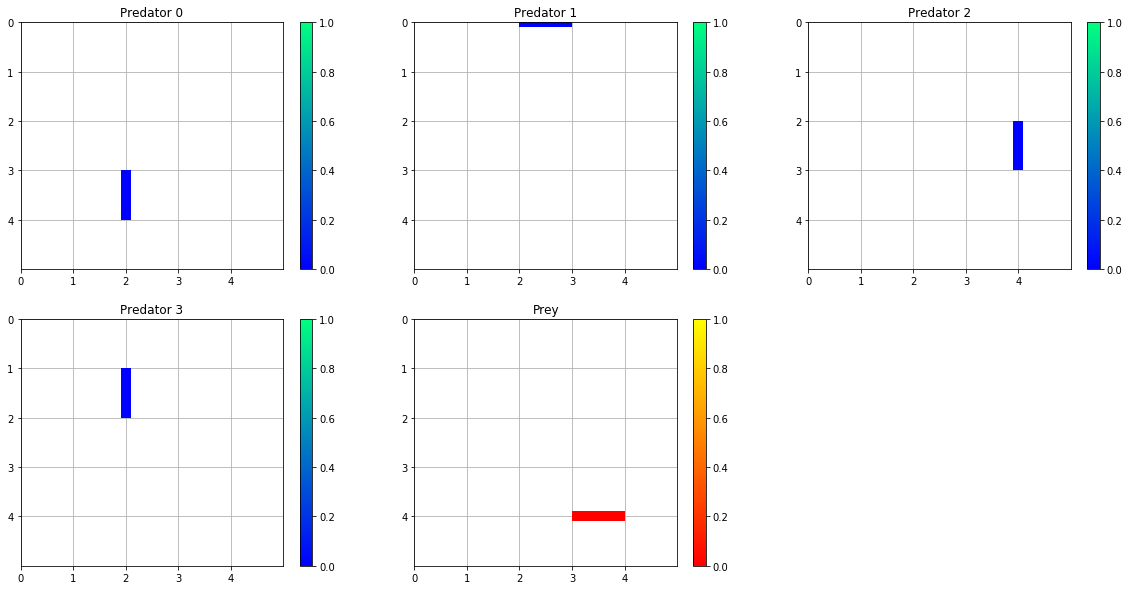

New policy rollout ? (y/n)y

Catched: True


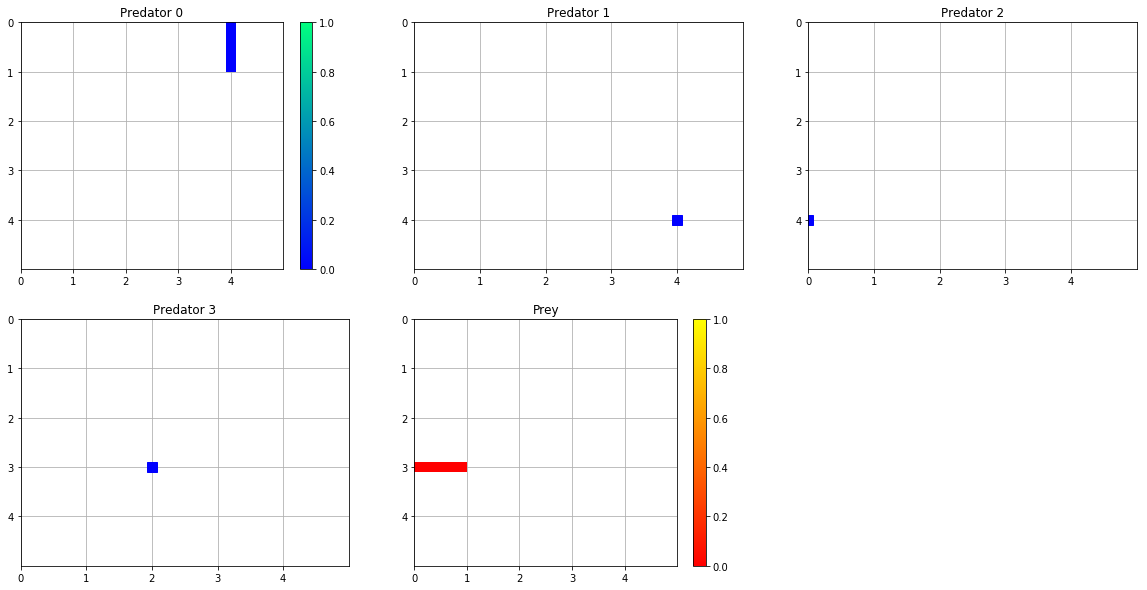

New policy rollout ? (y/n)y

Catched: True


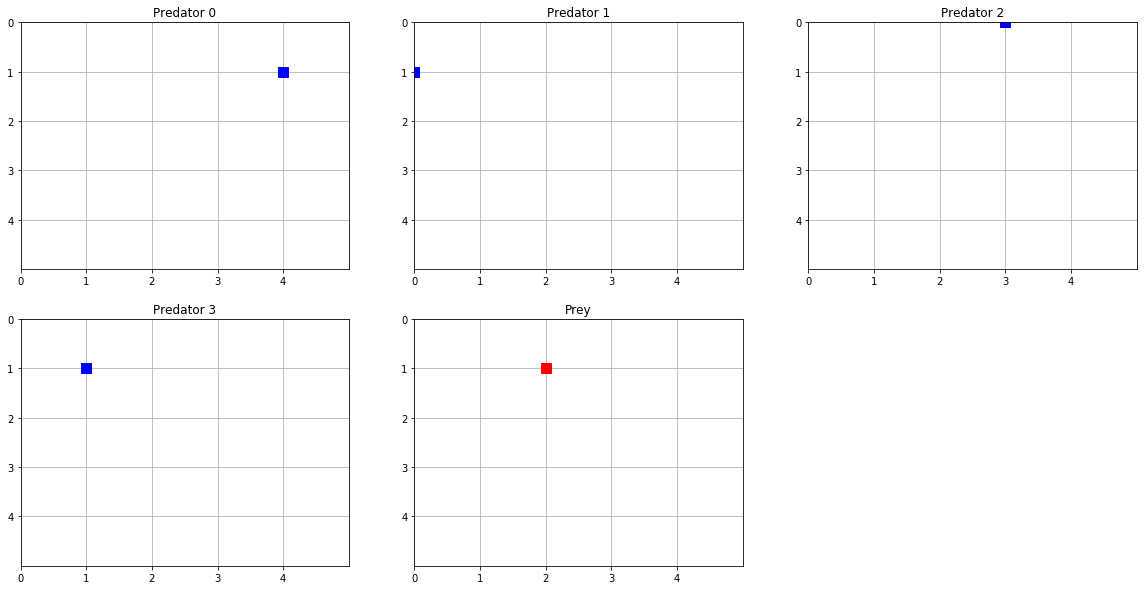

New policy rollout ? (y/n)y

Catched: True


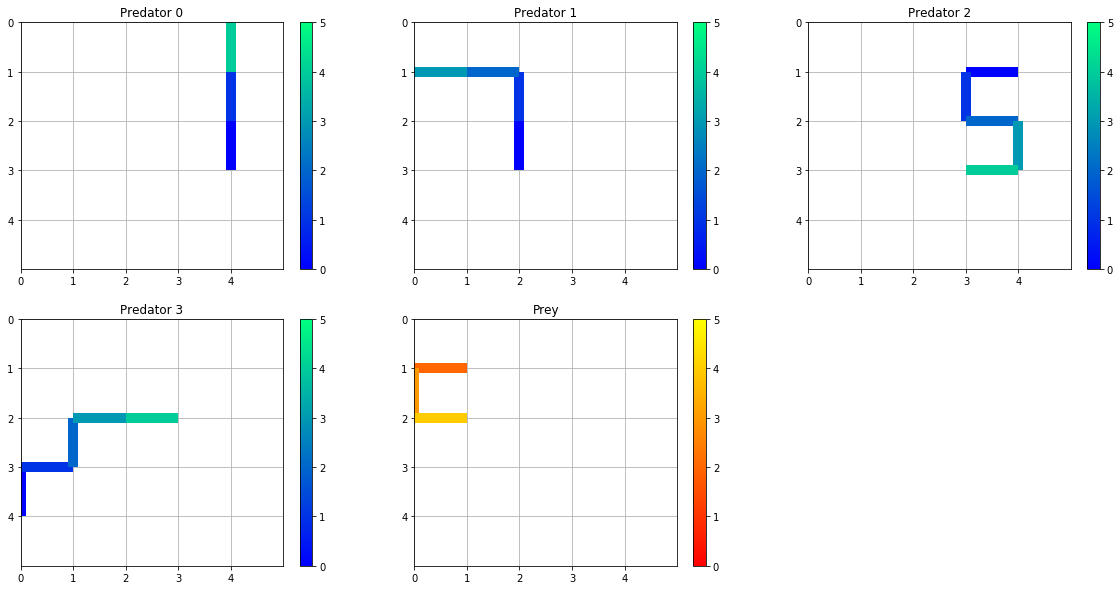

New policy rollout ? (y/n)y

Catched: True


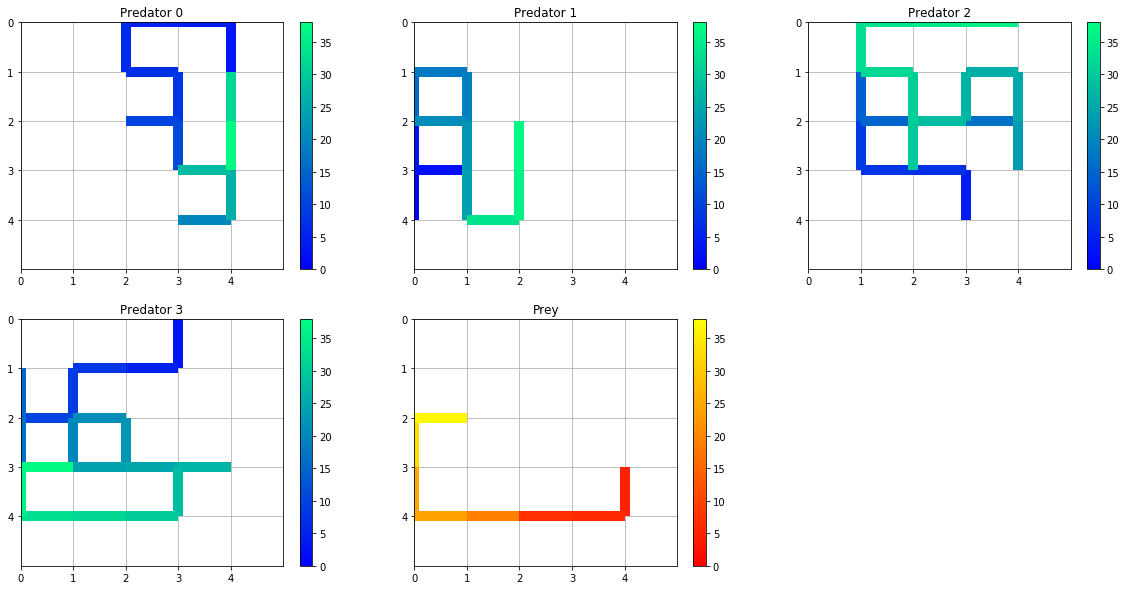

New policy rollout ? (y/n)y

Catched: True


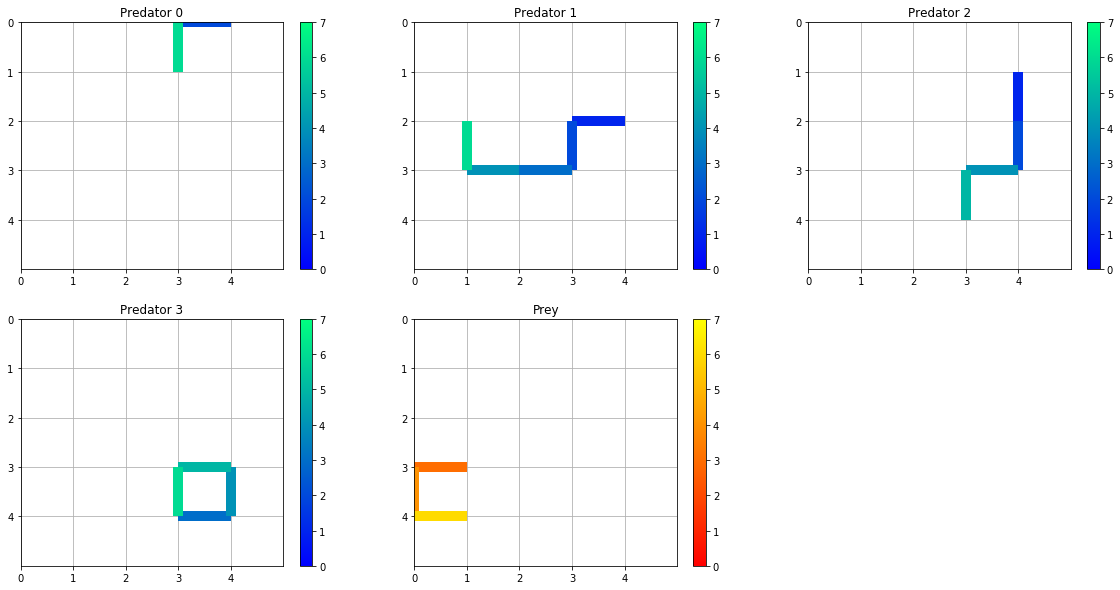

New policy rollout ? (y/n)y

Catched: True


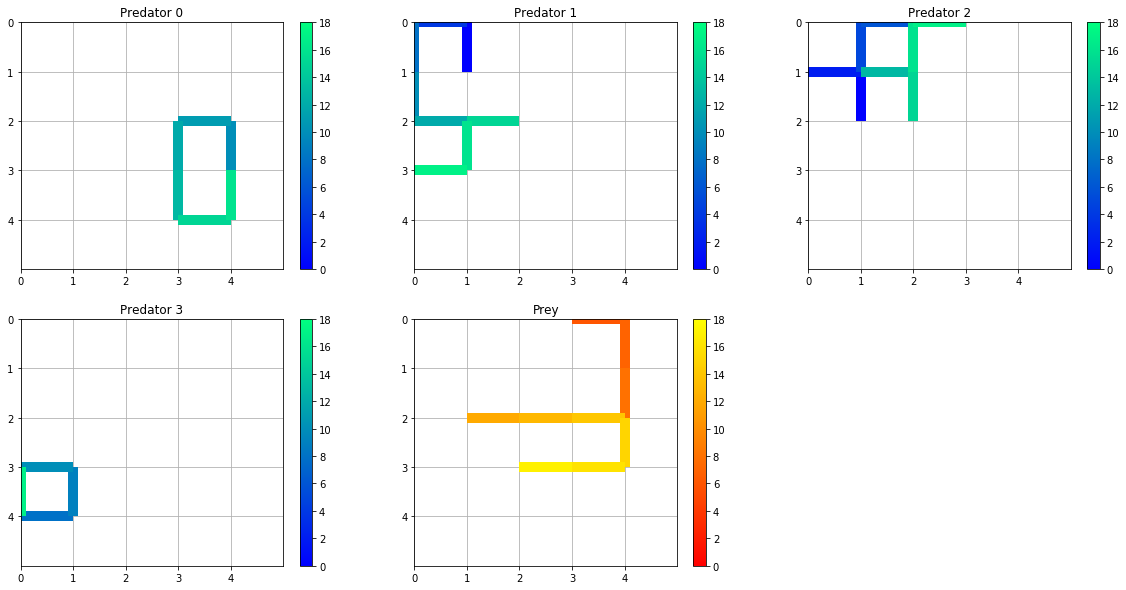

New policy rollout ? (y/n)y

Catched: True


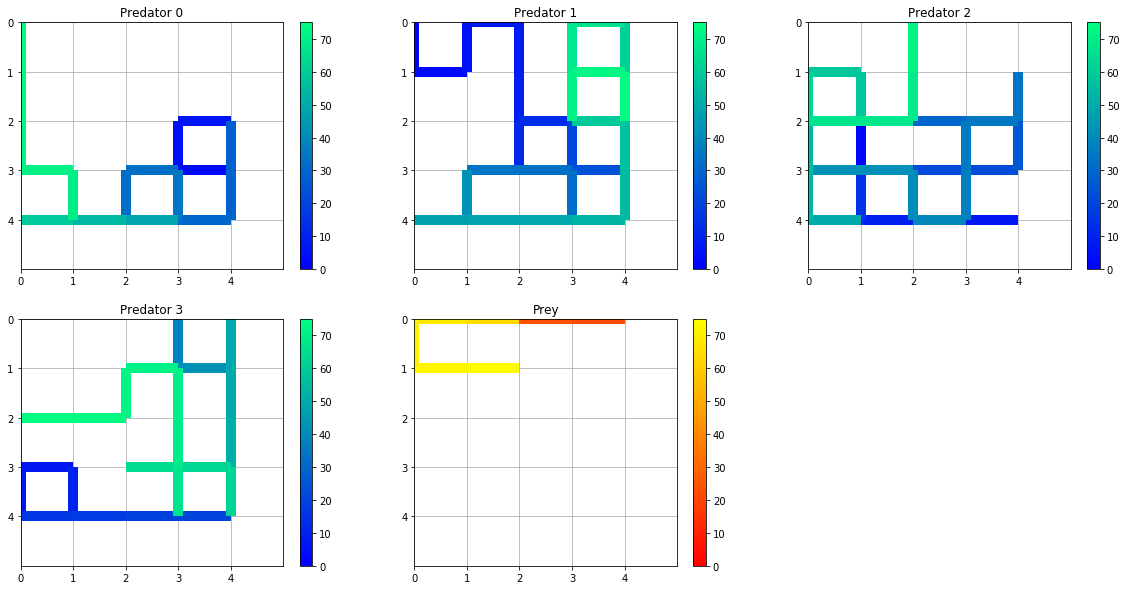

New policy rollout ? (y/n)y

Catched: True


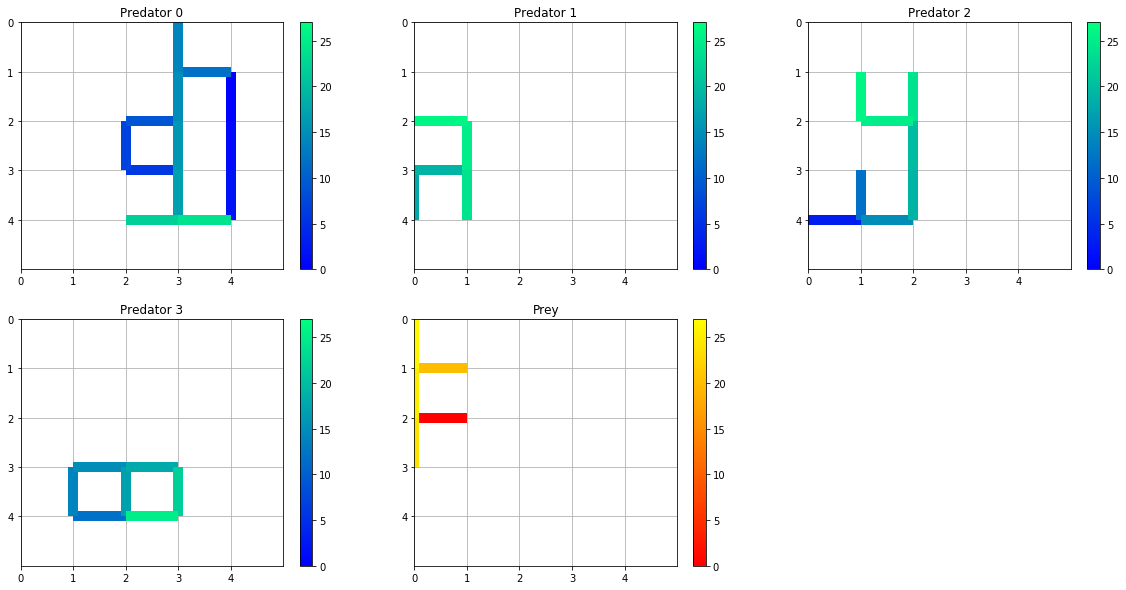

New policy rollout ? (y/n)y

Catched: True


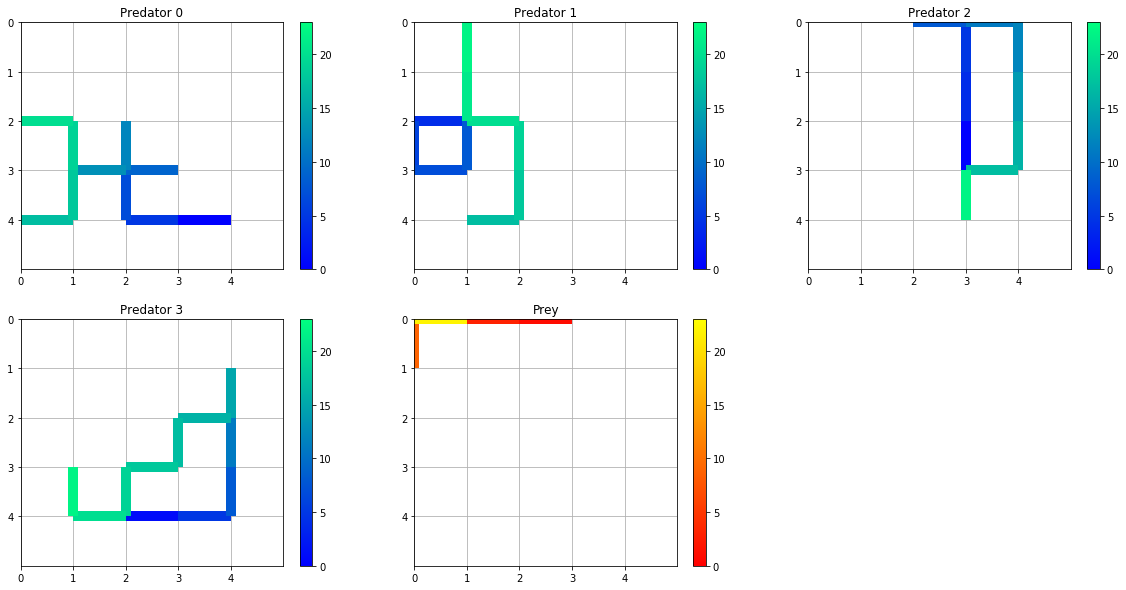

New policy rollout ? (y/n)n


In [10]:
tf.reset_default_graph()
with tf.Session() as sess:
    commNet = CommNetPP(sess, N,  grid_size, lr = 1e-3, rnn_controler = True, alpha = 0.06)
    env = PredatorPreyTask(N=N, grid_size=grid_size, detection_range=2, communication_cost=0.00, step_cost=0.1, forbidden_cost=0.1,
                prey_detection_range=2, uncatched_cost=1., T=T)    
    history = commNet.reinforce_train(env, n_episodes = n_episodes, T = T)
    
    W = 30
    print("avg reward")
    plt.plot(np.convolve(history['reward'], np.ones(W), 'valid')/W, '*')
    plt.show()
    print("reward")
    plt.plot(history['reward'], '*')
    plt.show()
    print("avg terminal_state")
    plt.plot(np.convolve(history['terminal_state'], np.ones(W), 'valid')/W, '*')
    plt.show()
    print("terminal_state")
    plt.plot(history['terminal_state'], '*')
    plt.show()
    print("loss")
    plt.plot(history['loss'], '*')
    plt.show()
    
    do_rollout = input("New policy rollout ? (y/n)")
    while do_rollout != "y" and do_rollout != "n":
        do_rollout = input("New policy rollout ? (y/n)")
    
    
    while do_rollout == "y":
    
        rollout = policy_rollout(T, env, commNet)
        
        print("\nCatched: %s" % bool(rollout['terminal_state']))
        
        pred_coord_history = np.array(env.pred_coord_history)
        prey_coord_history = np.array(env.prey_coord_history)
        plot_episode(pred_coord_history, prey_coord_history, grid_size)
        
        do_rollout = input("New policy rollout ? (y/n)")
        while do_rollout != "y" and do_rollout != "n":
            do_rollout = input("New policy rollout ? (y/n)")
            